# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana1100s0"     # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5761, 32, 32, 3)
(5761, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(128,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(64,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,32,3)))
#model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(128,activation="relu"))
#model.add(Dense(64,activation="relu"))
#model.add(Dense(2))
#model.summary()

#model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/30


C:\Users\Muell\AppData\Local\Temp\ipykernel_13144\3831122756.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


721/721 [==============================] - 10s 13ms/step - loss: 0.1511 - accuracy: 0.8729 - val_loss: 0.0244 - val_accuracy: 0.9783
Epoch 2/30
721/721 [==============================] - 9s 13ms/step - loss: 0.0194 - accuracy: 0.9674 - val_loss: 0.0138 - val_accuracy: 0.9801
Epoch 3/30
721/721 [==============================] - 9s 12ms/step - loss: 0.0104 - accuracy: 0.9757 - val_loss: 0.0056 - val_accuracy: 0.9766
Epoch 4/30
721/721 [==============================] - 9s 13ms/step - loss: 0.0057 - accuracy: 0.9825 - val_loss: 0.0041 - val_accuracy: 0.9870
Epoch 5/30
721/721 [==============================] - 9s 12ms/step - loss: 0.0040 - accuracy: 0.9823 - val_loss: 0.0033 - val_accuracy: 0.9879
Epoch 6/30
721/721 [==============================] - 9s 13ms/step - loss: 0.0030 - accuracy: 0.9870 - val_loss: 0.0044 - val_accuracy: 0.9844
Epoch 7/30
721/721 [==============================] - 9s 12ms/step - loss: 0.0025 - accuracy: 0.9892 - val_loss: 0.0045 - val_accuracy: 0.9835
Epoch 8/3

### Step 1: Learing result
 
* Visualization of the training and validation results

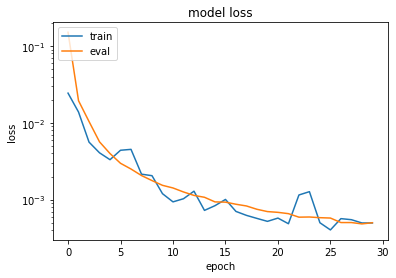

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
 11/721 [..............................] - ETA: 8s - loss: 0.3704 - accuracy: 0.7273

C:\Users\Muell\AppData\Local\Temp\ipykernel_13144\1492021130.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


721/721 [==============================] - 11s 15ms/step - loss: 0.0450 - accuracy: 0.9431 - val_loss: 0.0120 - val_accuracy: 0.9722
Epoch 2/160
721/721 [==============================] - 10s 14ms/step - loss: 0.0102 - accuracy: 0.9727 - val_loss: 0.0056 - val_accuracy: 0.9783
Epoch 3/160
721/721 [==============================] - 10s 14ms/step - loss: 0.0067 - accuracy: 0.9785 - val_loss: 0.0039 - val_accuracy: 0.9818
Epoch 4/160
721/721 [==============================] - 10s 14ms/step - loss: 0.0048 - accuracy: 0.9813 - val_loss: 0.0032 - val_accuracy: 0.9905
Epoch 5/160
721/721 [==============================] - 10s 14ms/step - loss: 0.0040 - accuracy: 0.9852 - val_loss: 0.0035 - val_accuracy: 0.9809
Epoch 6/160
721/721 [==============================] - 11s 15ms/step - loss: 0.0035 - accuracy: 0.9851 - val_loss: 0.0028 - val_accuracy: 0.9844
Epoch 7/160
721/721 [==============================] - 10s 14ms/step - loss: 0.0031 - accuracy: 0.9830 - val_loss: 0.0031 - val_accuracy: 0.98

Epoch 56/160
721/721 [==============================] - 11s 15ms/step - loss: 6.2755e-04 - accuracy: 0.9948 - val_loss: 5.8901e-04 - val_accuracy: 0.9905
Epoch 57/160
721/721 [==============================] - 10s 14ms/step - loss: 6.2516e-04 - accuracy: 0.9944 - val_loss: 5.8634e-04 - val_accuracy: 0.9939
Epoch 58/160
721/721 [==============================] - 11s 15ms/step - loss: 5.8521e-04 - accuracy: 0.9955 - val_loss: 5.3607e-04 - val_accuracy: 0.9965
Epoch 59/160
721/721 [==============================] - 11s 15ms/step - loss: 5.8227e-04 - accuracy: 0.9950 - val_loss: 6.5549e-04 - val_accuracy: 0.9879
Epoch 60/160
721/721 [==============================] - 10s 14ms/step - loss: 5.9916e-04 - accuracy: 0.9950 - val_loss: 5.6862e-04 - val_accuracy: 0.9983
Epoch 61/160
721/721 [==============================] - 11s 15ms/step - loss: 6.1211e-04 - accuracy: 0.9941 - val_loss: 5.8916e-04 - val_accuracy: 0.9974
Epoch 62/160
721/721 [==============================] - 11s 15ms/step - loss

721/721 [==============================] - 12s 17ms/step - loss: 4.2000e-04 - accuracy: 0.9965 - val_loss: 3.8849e-04 - val_accuracy: 0.9957
Epoch 110/160
721/721 [==============================] - 12s 17ms/step - loss: 4.1062e-04 - accuracy: 0.9960 - val_loss: 3.6232e-04 - val_accuracy: 0.9974
Epoch 111/160
721/721 [==============================] - 12s 17ms/step - loss: 3.9594e-04 - accuracy: 0.9969 - val_loss: 3.7162e-04 - val_accuracy: 0.9974
Epoch 112/160
721/721 [==============================] - 12s 17ms/step - loss: 4.0631e-04 - accuracy: 0.9969 - val_loss: 3.8879e-04 - val_accuracy: 0.9939
Epoch 113/160
721/721 [==============================] - 12s 17ms/step - loss: 3.9019e-04 - accuracy: 0.9957 - val_loss: 4.0167e-04 - val_accuracy: 0.9957
Epoch 114/160
721/721 [==============================] - 12s 17ms/step - loss: 4.1357e-04 - accuracy: 0.9964 - val_loss: 3.3567e-04 - val_accuracy: 0.9983
Epoch 115/160
721/721 [==============================] - 12s 17ms/step - loss: 3.951

### Overall Learing results (Step 1 & Step 2)

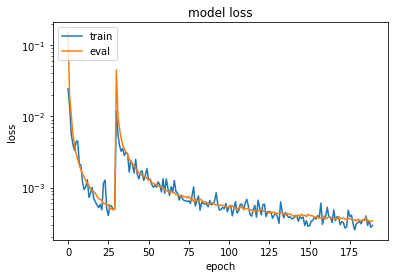

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\4.3_PRODUCED_ANALOG_2.jpg 0.43 0.37357564088853645 0.05642435911146354
data_resize_all\4.4_PRODUCED_ANALOG.jpg 0.44000000000000006 0.38769515972276836 0.0523048402772317
data_resize_all\4.4_PRODUCED_ANALOG_2.jpg 0.44000000000000006 0.37801598481345716 0.061984015186542896
data_resize_all\5.6_2760_zeiger4_2020-04-29_13-09-02.jpg 0.5599999999999999 0.6429735280154505 -0.08297352801545055
data_resize_all\5.9.jpg 0.5900000000000001 0.8549936989100476 -0.26499369891004754
data_resize_all\6.4_PRODUCED_ANALOG_2.jpg 0.64 0.6947819168533267 -0.05478191685332667
data_resize_all\6.5_3349_zeiger2_2020-04-29_13-48-02.jpg 0.65 0.7017860861196978 -0.051786086119697816
data_resize_all\9.4_PRODUCED_ANALOG_2.jpg 0.9400000000000001 1.012748291953735 -0.07274829195373489
data_resize_all\9.6_PRODUCED_ANALOG.jpg 0.96 1.0192373001309416 -0.05923730013094164
data_resize_all\9.7_PRODUCED_ANALOG_2.jpg 0.97 1.0214016554554814 -0.051401655455481476
data_resize_all\9.8_PRODUCED_ANALOG.jpg 0.9800000

## Results

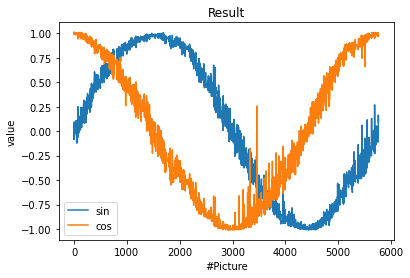

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

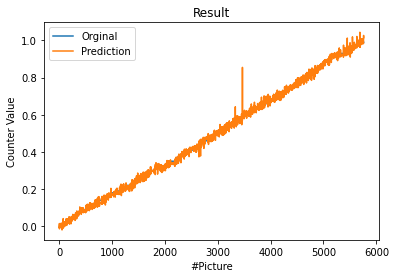

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

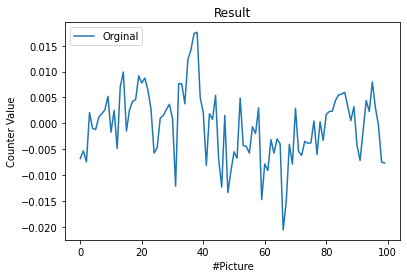

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

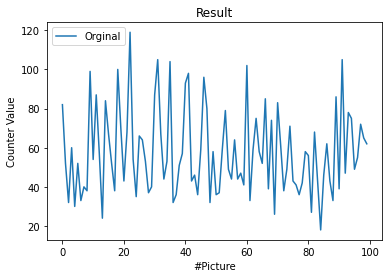

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

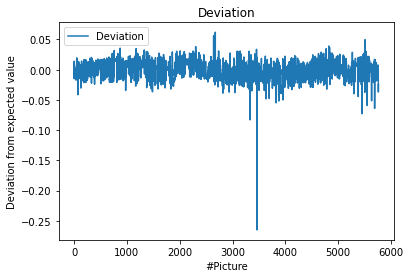

[-0.0005  0.0134 -0.265   0.062 ]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyyz9s2z0\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyyz9s2z0\assets


365580

In [15]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[n], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkblcs12g\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpkblcs12g\assets
C:\Users\Muell\anaconda3\envs\py39-tf-opencv\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


ana1100s0.tflite


100080